# Exploratory Data Analysis


## Table of Contents
* 1. [Analysis of Trends by Category](#trendcat)
    * 1.1. [Analysis of Household Items](#housenal)
    * 1.2. [Analysis of Food Items](#foodnal)
    * 1.3. [Analysis of Hobby Items](#hobbyal)
* 2. [Analysis by store ID](#storeid)

* 3. [Analysis Grouping both Store and Cat](#storencat) 

* 4. [Interaction Price and Sales Volume](#salesvol)

* 5. [SNAP and when it affects sales](#snapaffect)

<a id = 'trendcat'></a>
### Analysis of Trends grouped by Category


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


Bad key "text.kerning_factor" on line 4 in
C:\Users\Jerry\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
CA_train = pd.read_pickle('CA_train.pkl')

Create grouping based on category

In [4]:
grouped = CA_train.groupby(['cat_id','date'])['value'].sum()

Create grouping based on store id

In [5]:
group_shop = CA_train.groupby(['store_id','date'])['value'].sum()

In [6]:
indexing = np.array(grouped.index.get_level_values(level=0).unique().categories)

create grouping based on store id and category

In [7]:
grouping_catnstore = CA_train.groupby(['store_id', 'cat_id','date'])['value'].sum()
idx = pd.IndexSlice
grouping_catnstore = grouping_catnstore.loc[idx['CA_1':'CA_4',:]].copy()

Create a function to plot a full distribution based on the grouped object

In [8]:
def plot_full(group_object,list_group, time_period, time):
    plt.figure(figsize=(15,6))
    for i in list_group:
        group_object[i].plot(x='date', y = 'value',label = i)
        if time:
            group_object[i].rolling(time_period).mean().plot(x='date',y='value', label = 'ROLLING MEAN ' + str(i))
    for i in list_group:
        plt.axhline(group_object[i].mean(),color = 'red')
        if time:
            plt.text(pd.Timestamp(2011,2,1),group_object[i].mean()+200, str(group_object[i].mean()), color = 'red')

    plt.legend()
    plt.show()
    return

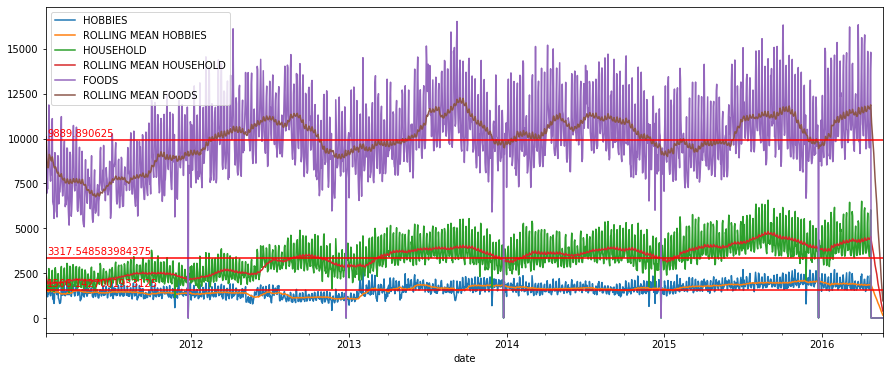

In [9]:
plot_full(grouped, indexing, '30D', True)

Overall, Food items have the highest number of sales, followed by household items and hobby items have the lowest number of sales. 

It does seem that (sum of) sales of the item all plummet at one particular date/time every year.
In detecting Seasonality, we deduce that there is hardly any **trend** in the *HOBBIES* category, however, the data does seem to suggest that there might be trend, particularly for household.

Food Remains relatively stable as well, with a slight increasing trend, but this might be due to white noise. There is definitely a seasonal trend throughout the year


Looking into the year of 2014,

In [10]:
def plot_timeperiod(group_object,list_grp,start_y,start_m,start_d,end_y,end_m,end_d):
    plt.figure(figsize=(15,5))
    for i in list_grp:
        group_object[i][(group_object[i].index>pd.Timestamp(start_y,start_m,start_d)) & 
                   (group_object[i].index<=pd.Timestamp(end_y,end_m,end_d))].plot(x='date',y='value', 
                                                                         label = i)
    plt.legend()
    plt.show()

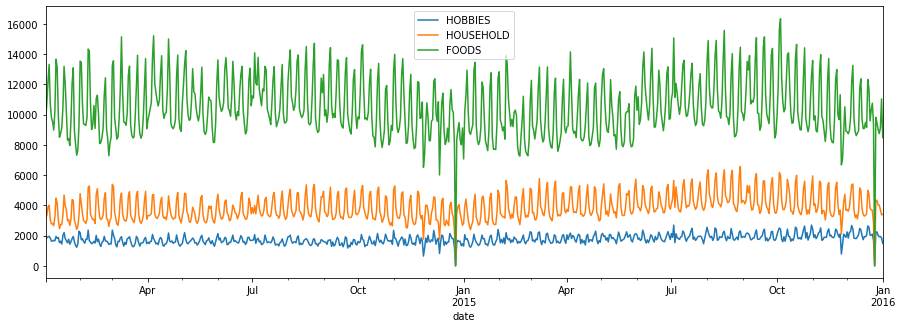

In [11]:
plot_timeperiod(grouped,indexing,2014,1,1,2016,1,1)

Going further deeper, we look into the year of 2014 december,

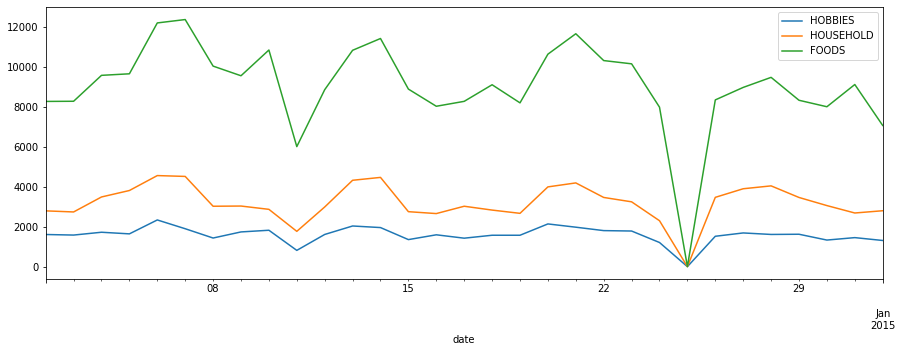

In [12]:
plot_timeperiod(grouped,indexing,2014,12,1,2015,1,1)

It seems that for all Categories across all store id and items, the sales plummets to 0 or close to 0 on Christmas

Furthermore, there is definitely a seasonal trend (To household and FOOD items) whereby every week exhibits a peak(at the end of the week (on sunday))


Next, we look further into the breakdown of items sold per shop.

In [13]:
grouping_withoutdate = CA_train.groupby(['store_id','cat_id'])['value'].sum()

In [14]:
idx = pd.IndexSlice
grouping_withoutdate = grouping_withoutdate.loc[idx['CA_1':'CA_4',:]].copy()

In [15]:
def plot_items_shop(grouped_object):
    grouped_object.plot(kind='bar', rot = 0, figsize = (15,6))
    plt.show()
    return 

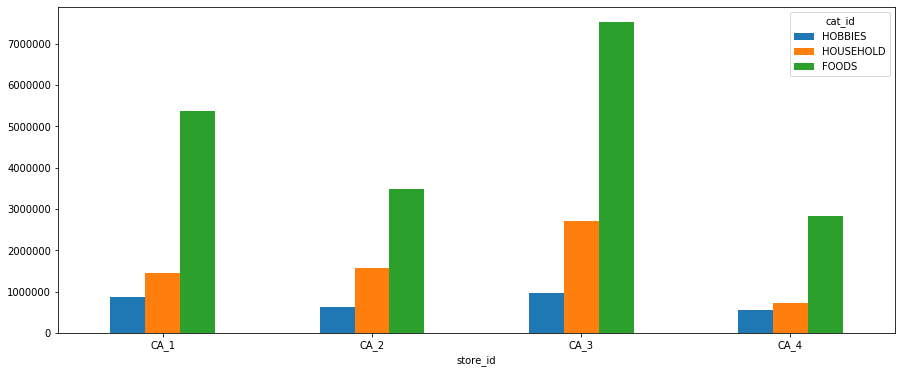

In [16]:
plot_items_shop(grouping_withoutdate.unstack())

It seems that CA_3 has the highest sales overall. This could be due  to the fact that it is located in a much denser area as compared to the other stores, or that the store could be larger and hence, attracts more people to go to the store

<a id = 'housenal'></a>
### Analysis of Household items


Create a dictionary to use the following function, whereby the key and values should be:<br>
$\bullet$ 'model' : 'additive' or 'multiplicative', <br>
$\bullet$ 'x' : (grouped) data that you want to decompose, can be subsetted to time period that u are interested in<br>

In [17]:
def plot_composition(**kwargs):
    result = seasonal_decompose(**kwargs).plot()
    plt.show()
    return

In [18]:
def plotting_acf_pacf(title,object_wanted,lags):
    fig,axes = plt.subplots(1,2, figsize= (12,3))
    plt.figure(figsize=(7,2))
    fig = plot_acf(object_wanted, lags = lags,ax=axes[0])
    fig = plot_pacf(object_wanted,lags=lags, ax = axes[1])
    fig.suptitle(title)
    plt.show()
    return

Resampling by month, we can actually determine some form of trend

In [19]:
model_wanted = {'model': 'additive', 'x': grouped.HOUSEHOLD.resample('M').mean()}
title = 'ACF, PACF plots for Household Items'

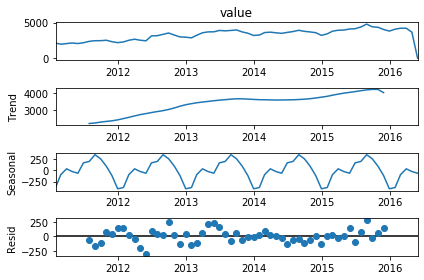

In [20]:
plot_composition(**model_wanted)

From the decompositon, we can tell that there is a clear upwards trend in value (or number of sales) of household items  through the years, There is indeed monthly seasonality in the plot, where the peak of seasonal purchases actually happen sometime in may-august period

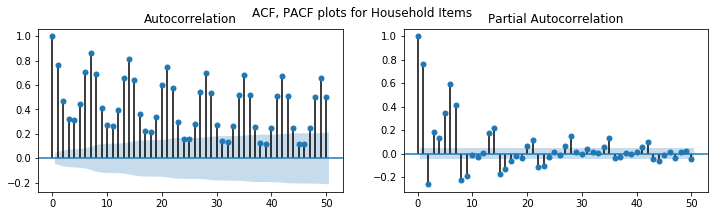

<Figure size 504x144 with 0 Axes>

In [21]:
plotting_acf_pacf(title,grouped.HOUSEHOLD,50)

It seems that there is also some seasonality every 7 days, whereby we can see that the cycle or the trend repeats itself every 7 days. 

Scalloped shape of ACF plot is due to seasonality.

**We can therefore, consider a 7 day differencing in our model for household items**

In [22]:
model_year = {'x': grouped.HOUSEHOLD[(grouped.HOUSEHOLD.index>pd.Timestamp(2015,1,1)) & 
               (grouped.HOUSEHOLD.index<=pd.Timestamp(2016,1,1))], 'model':'additive' }

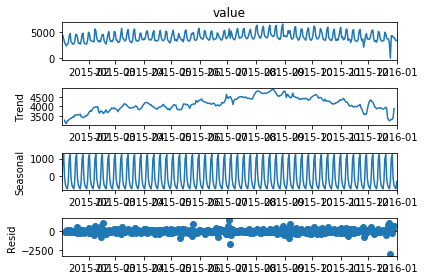

In [23]:
plot_composition(**model_year)

There is definitely seasonality throughout a year and this can be seen from the 52 peaks in the seasonal graph. What this represents is that there is some cyclic nature every week of the year. Furthermore, it can b determined that there is some kind of peak during the may-august period

<a id= 'foodnal'></a>
### Analysis of Food Items


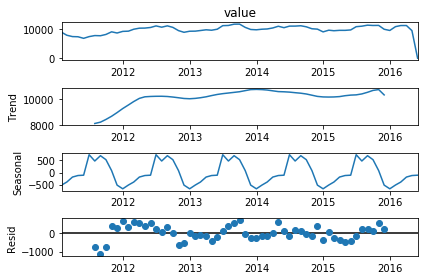

In [24]:
title = 'ACF,PACF Plots for Food Items'
model_food = {'model': 'additive', 'x': grouped.FOODS.resample('M').mean()}
plot_composition(**model_food)

In [25]:
model_5_food = {'model': 'additive','x': grouped.FOODS[(grouped.FOODS.index>pd.Timestamp(2015,1,1)) & 
               (grouped.FOODS.index<=pd.Timestamp(2016,1,1))]}

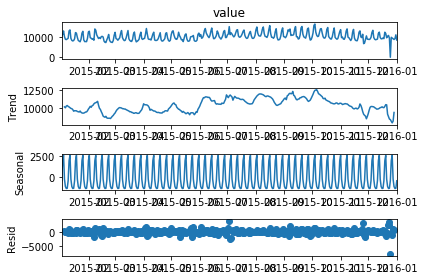

In [26]:
plot_composition(**model_5_food)

Similarly, it is a weekly trend that shows that the model food is also restocked every week. 

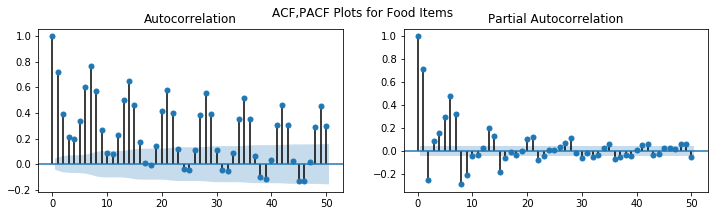

<Figure size 504x144 with 0 Axes>

In [27]:
plotting_acf_pacf(title,grouped.FOODS, 50)

Similarly, it seems that there is too, a 7 day seasonality from  the Autocorrelation plot, **we can therefore make use of a 7 day differencing as well.**

<a id= 'hobbyal'></a>
### Analysis of Hobby items


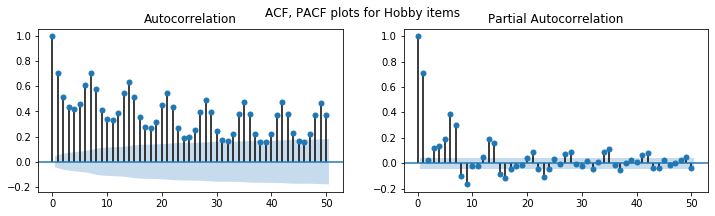

<Figure size 504x144 with 0 Axes>

In [28]:
title = 'ACF, PACF plots for Hobby items'
plotting_acf_pacf(title,grouped.HOBBIES, 50)

There also seems to be a 7 day trend for Hobby items, although it is not as pronounced

In [29]:
model_hobbies = {'x': grouped.HOBBIES.resample('M').mean(), 'model': 'additive'}

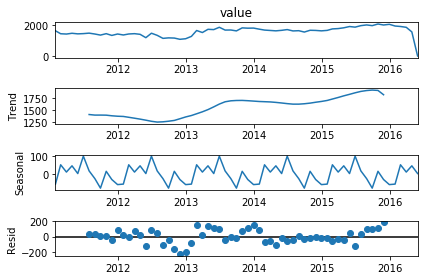

In [30]:
plot_composition(**model_hobbies)

There seems to be a slight trend whereby the sales values decreased in 2013 and rose substantially afer year 2013

Similarly, there is a seasonal trend as well, and it seems that in may, the number of hobby items are at the peak. This could likely be because it is during summer and people/students have more time to pursue their hobbies during summer, hence, the increase in sales of items during summer.

<a id = 'storeid'></a>
## Analysis of Time Series with Shop ID


In this section, we consider grouping by Shop ID within the state, to find out if there are any trends within the shops themselves

In [31]:
index_shops = np.array(group_shop.index.get_level_values(level=0).categories)

In [32]:
index_shops = np.delete(index_shops,[4,5,6,7,8,9],None)

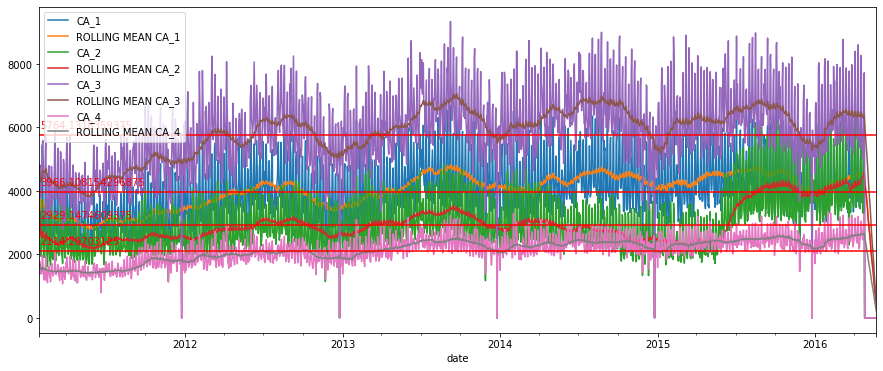

In [33]:
plot_full(group_shop, index_shops, '30D', True)

It seems that all shops have shown an increasing trend of sales accross all products accross the years.

**CA_3 has the largest number of sales**

Similarly, for every single shop, it seems that there is a specific day where there is almost no sales.

We will delve into the detail

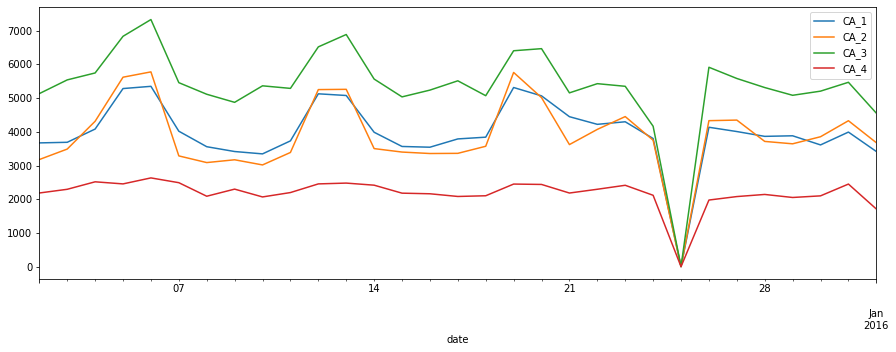

In [34]:
plot_timeperiod(group_shop, index_shops, 2015,12,1,2016,1,1)

Indeed, it is also almost 0 during christmas. This proves that there are almost no sales across all shops and items during the christmas holidays in USA. 

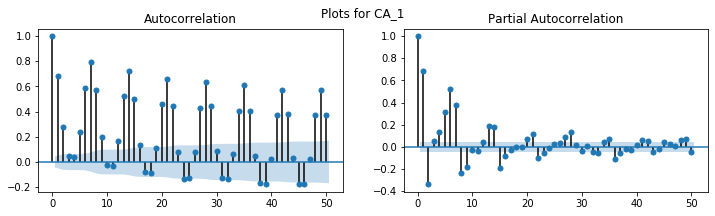

<Figure size 504x144 with 0 Axes>

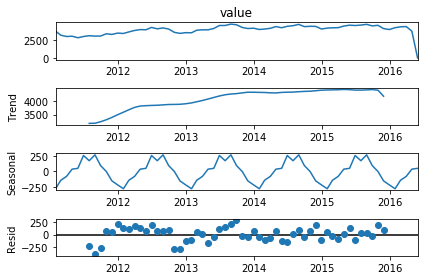

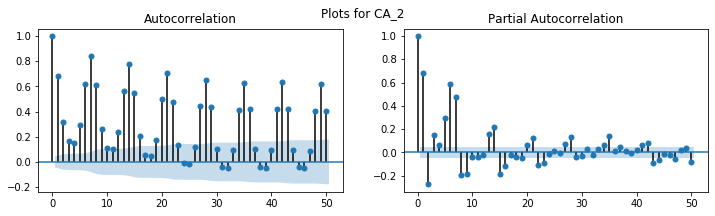

<Figure size 504x144 with 0 Axes>

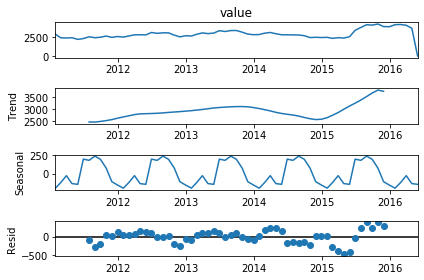

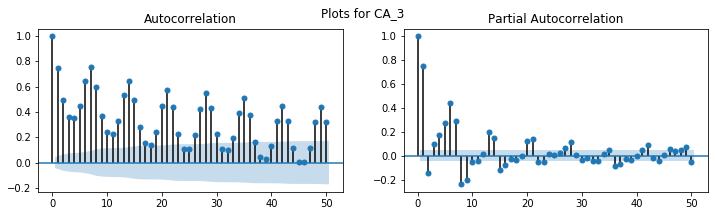

<Figure size 504x144 with 0 Axes>

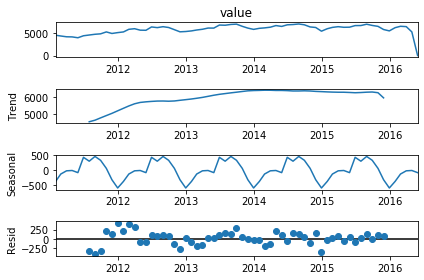

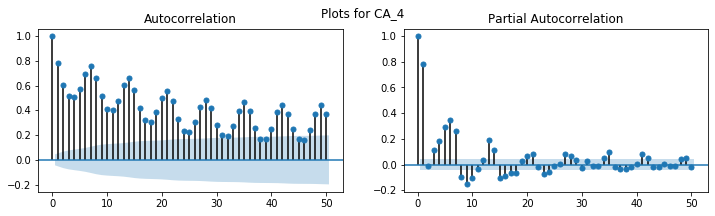

<Figure size 504x144 with 0 Axes>

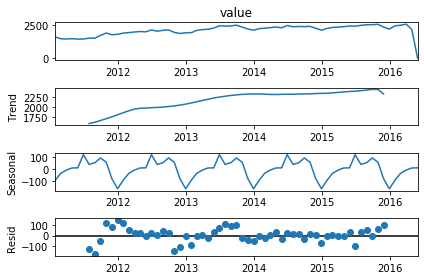

In [35]:
model_shop_listing = []
for i,shop_name in enumerate(index_shops):
    model_shop_listing.append({'x': group_shop[shop_name].resample('M').mean(), 'model':'additive'})
    title = 'Plots for ' + shop_name
    plotting_acf_pacf(title,group_shop[shop_name],50)
    plot_composition(**model_shop_listing[i])
    

From the Autocorrelation plots,  ALL shops exhibit seasonality in the sense that each 'season' or cycle repeats every 7 days However, this might be attributed due to FOODS, which we have identified, exhibit a weekly trend.

Also, across all the months, it is clear that we have a seasonal trend that displays highest amount sales during summer.

Also, it seems that albeit slight in CA_1 and CA_2 , sales in all stores exhibit an increasing trend

<a id = 'storencat'></a>
### We consider diving further deeper in detail

This is in order to find out if the increase in sales over time in the shops is attributed to the category of items that are sold or if it is an increase due to an increase in population within the region of the shop or perhaps a downsizing/upsizing of the shop

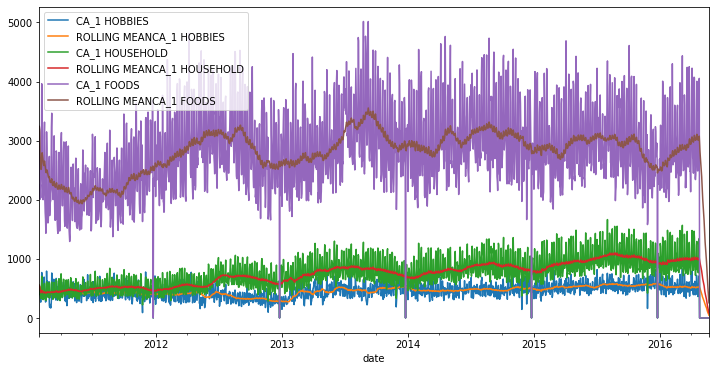

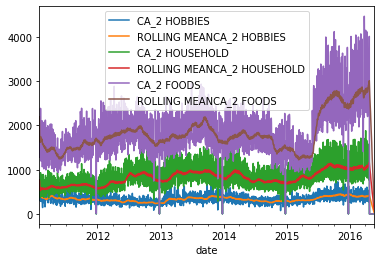

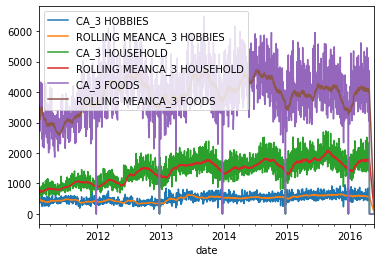

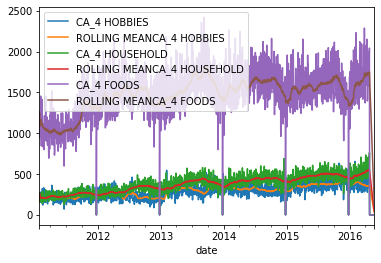

In [36]:
index_shops = grouping_catnstore.index.get_level_values(level=0).unique()
index_cat = grouping_catnstore.index.get_level_values(level=1).unique()
plt.figure(figsize = (12,6))
for i in index_shops:
    for j in index_cat:
        grouping_catnstore[i][j].plot(x='date',y='value', label = i+' ' + j)
        grouping_catnstore[i][j].rolling('30D').mean().plot(x = 'date', y= 'value', 
                                                            label = 'ROLLING MEAN' + i + ' ' + j )
    plt.legend()
    plt.show()

As a whole, it seems that HOUSEHOLD items have seen an increase in sales overall.(across all stores in CA). There is a very obvious upward trend.

Similarly, FOOD itemshave shown a slight upwawrd trend as well - possibly because more people could be lifted out of poverty/ increased wages in the area.

This can be further proven using a seasonal decomposition of each of the variables

One thing, however, remains constant. That is - HOBBIES.

Amount of sales in hobbyist items are still relatively constant across all shops,

Although it does seem that overall, all categories of items in CA_4 have experienced increased sales as time passes.

CA_2 has seen a sharp increase in sales of FOOD items past 2015. This could be due to an expansion in the food sector



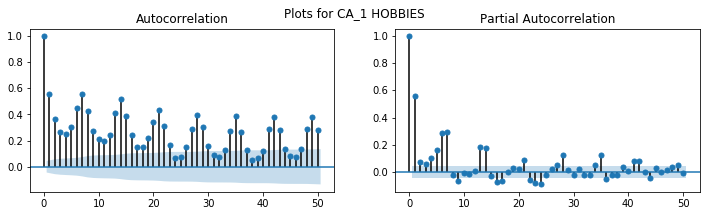

<Figure size 504x144 with 0 Axes>

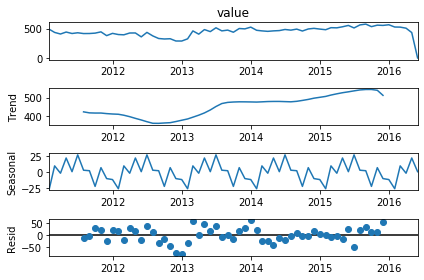

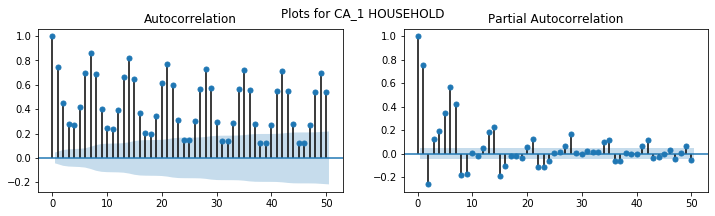

<Figure size 504x144 with 0 Axes>

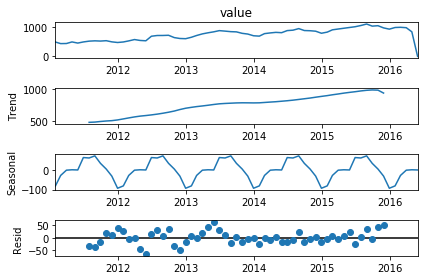

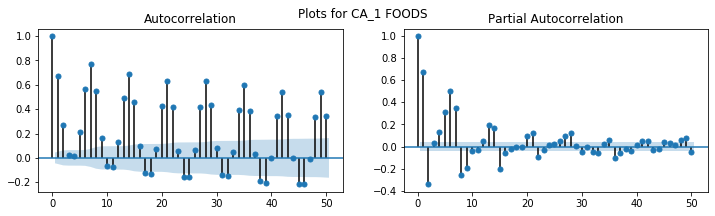

<Figure size 504x144 with 0 Axes>

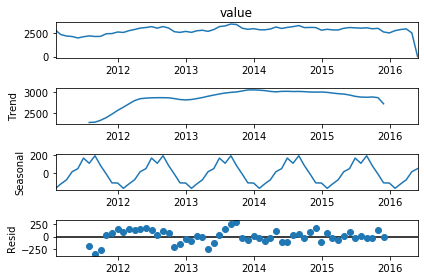

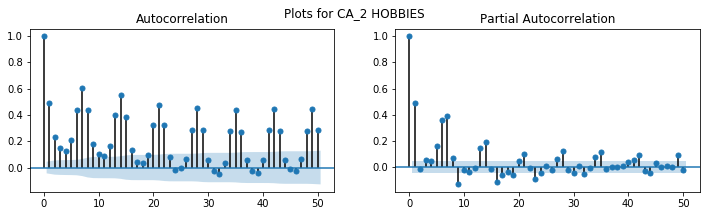

<Figure size 504x144 with 0 Axes>

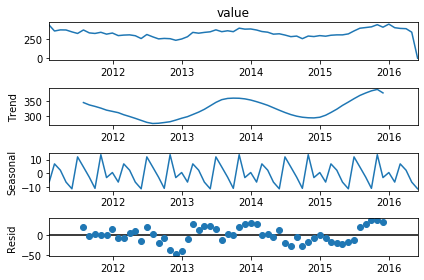

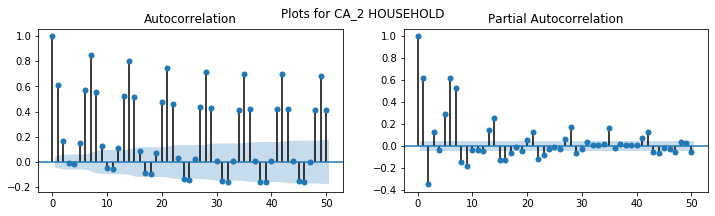

<Figure size 504x144 with 0 Axes>

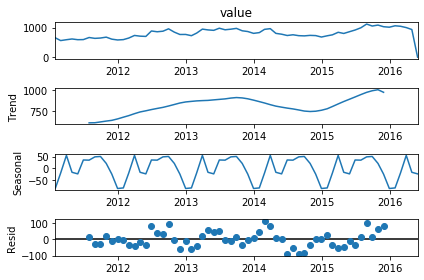

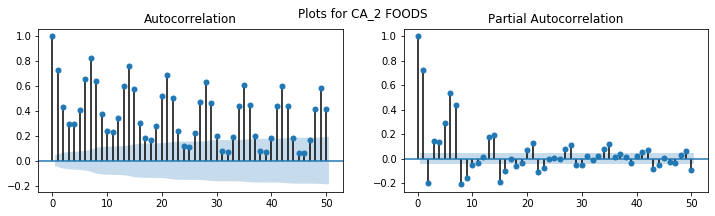

<Figure size 504x144 with 0 Axes>

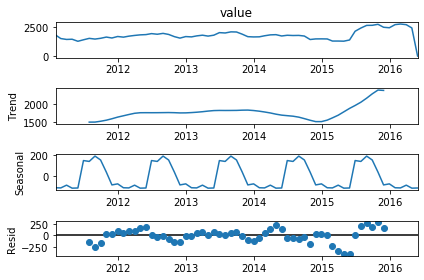

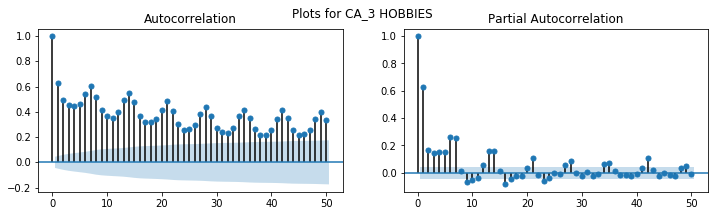

<Figure size 504x144 with 0 Axes>

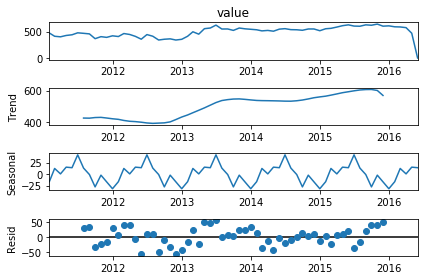

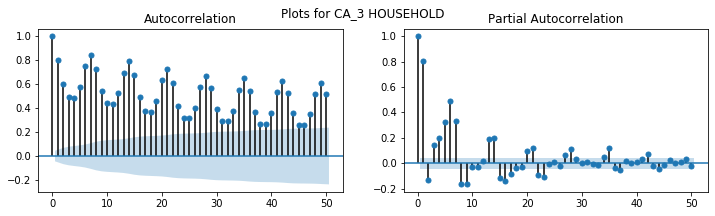

<Figure size 504x144 with 0 Axes>

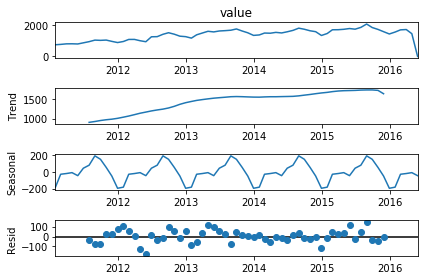

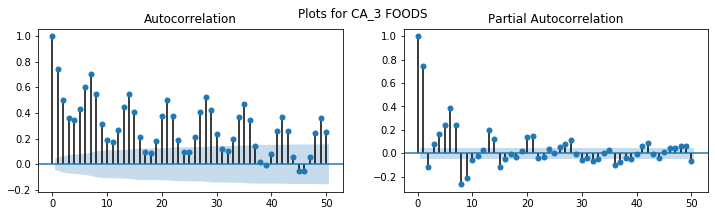

<Figure size 504x144 with 0 Axes>

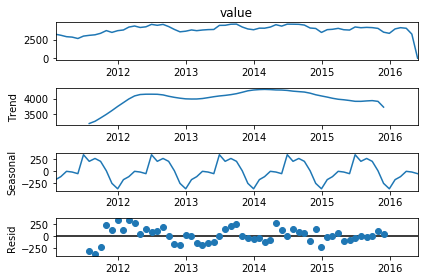

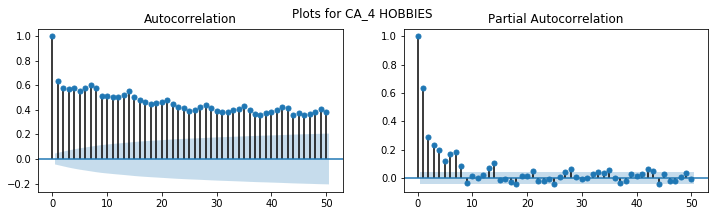

<Figure size 504x144 with 0 Axes>

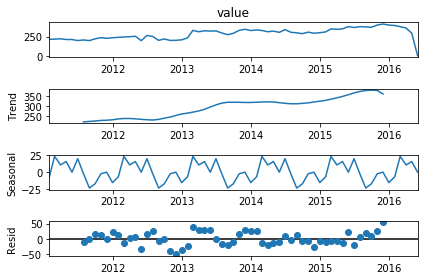

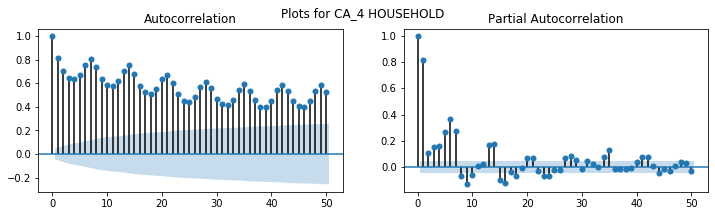

<Figure size 504x144 with 0 Axes>

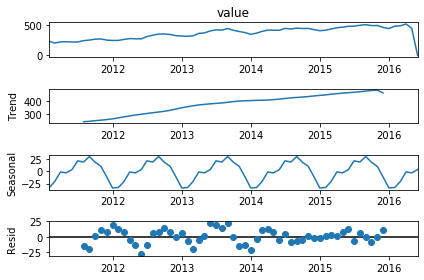

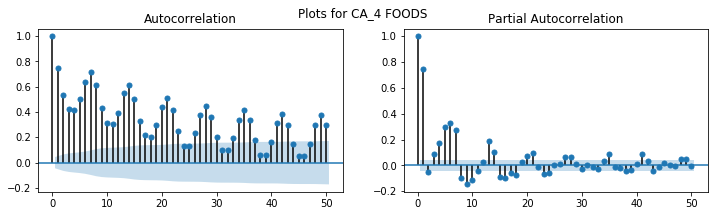

<Figure size 504x144 with 0 Axes>

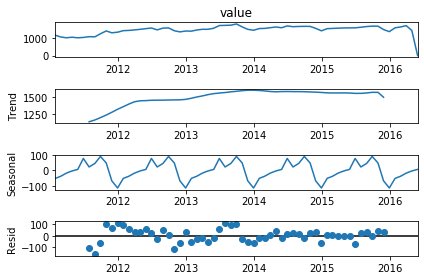

In [37]:
model_catnstore_listing = []
for i,shop_name in enumerate(index_shops):
    model_catnstore_listing.append([])
    for j,cat in enumerate(index_cat):
        model_catnstore_listing[i].append({'x': grouping_catnstore[shop_name][cat].resample('M').mean(),
                                         'model':'additive'})
        title = 'Plots for ' + shop_name + ' ' + cat
        plotting_acf_pacf(title,grouping_catnstore[shop_name][cat],50)
        plot_composition(**model_catnstore_listing[i][j])
        

The plots are representative of the hypothesis made earlier.

Strangely enough, It seems that even Food and Household items also experience higher sales during the summer.

Also, foods from CA_1 and CA_2 as well as HOBBIES from CA_1 show fairly high correlation, even despite higher lags.

<a id = 'salesvol'></a>
### Consider the interaction between Prices and Sales Volume - Will there be any correlation?


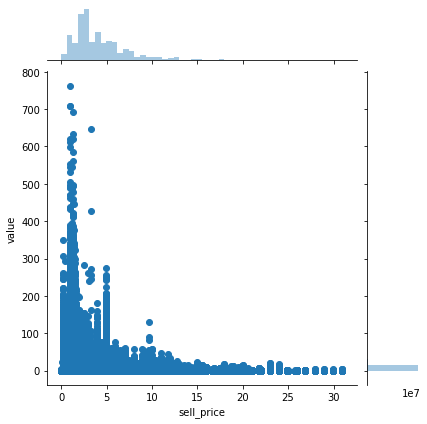

In [38]:
sns.jointplot(CA_train['sell_price'], CA_train['value'])
plt.show()

It seems quite clear, that a relationship can be established, higher valued items will not sell as much as lower values items. 

In [39]:
grouped_agg = CA_train.groupby(['cat_id','date']).agg({
    'value':np.sum, 'sell_price':'mean'}).rename(columns={
    'value': 'sum_val', 'sell_price': 'avg_price'})

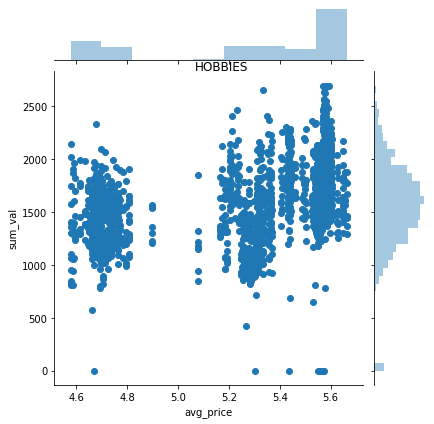

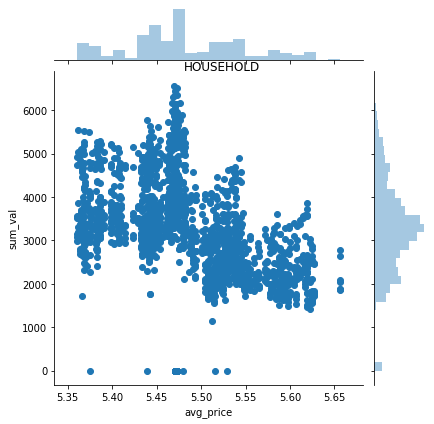

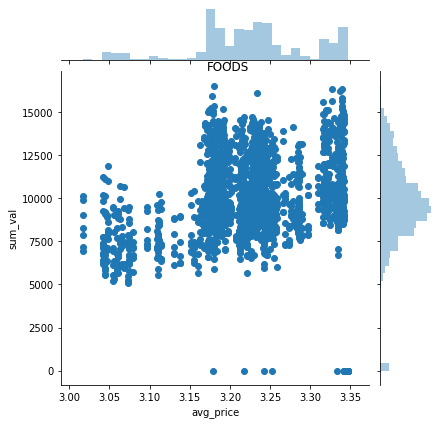

In [40]:
for i in grouped_agg.index.get_level_values(level=0).unique():
    plots = sns.jointplot(grouped_agg.loc[i].avg_price,grouped_agg.loc[i].sum_val)
    plots.fig.suptitle(i, y=0.85)
    plt.show()

We were expecting something along the lines of low values correspond to low prices, this seems to only show (*slighly*) in the case of household items. Hobbies does not exhibit any relationship.

Interestingly, it seems that a fair number of goods of high price also has high value. This could possibly be because people could view low valued foods as 'unsafe' of sorts.

Since the jointplot may not be representative of the relationship between prices and volume of items bought, we plot a time series of vol and price.

We have to take the mean of sales volume every 7 days as the price only changes every 7 days. (This is done by resampling to calculate by week). 

Note that Scaling was done to the dataset so that we can get a better visualisation to identify the relationship between the 2

Because of that fact, we can also look into whether or not a change in price could be a good indicator of whether or not more/less sales are made, and whether that is a viable option as a feature

In [52]:
sales_price = grouped_agg.groupby(['cat_id'] +[pd.Grouper(freq='W', level=-1)]).mean()

In [53]:
sales_price.rename(columns = {'sum_val':'avg_val'}, inplace = True)

In [54]:
from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()
transformed = ss.fit_transform(sales_price)

In [55]:
sales_price['avg_val'] = transformed[:,0]
sales_price['avg_price'] = transformed[:,1]

In [56]:
sales_price

avg_val  avg_price
cat_id  date                           
HOBBIES 2011-01-30  0.127864   0.617548
        2011-02-06  0.111879   0.615788
        2011-02-13  0.115876   0.606653
        2011-02-20  0.095877   0.593730
        2011-02-27  0.113421   0.591162
...                      ...        ...
FOODS   2016-04-24  0.872185   0.122781
        2016-05-01  0.000000   0.123246
        2016-05-08  0.000000   0.123789
        2016-05-15  0.000000   0.124207
        2016-05-22  0.000000   0.124829

[834 rows x 2 columns]

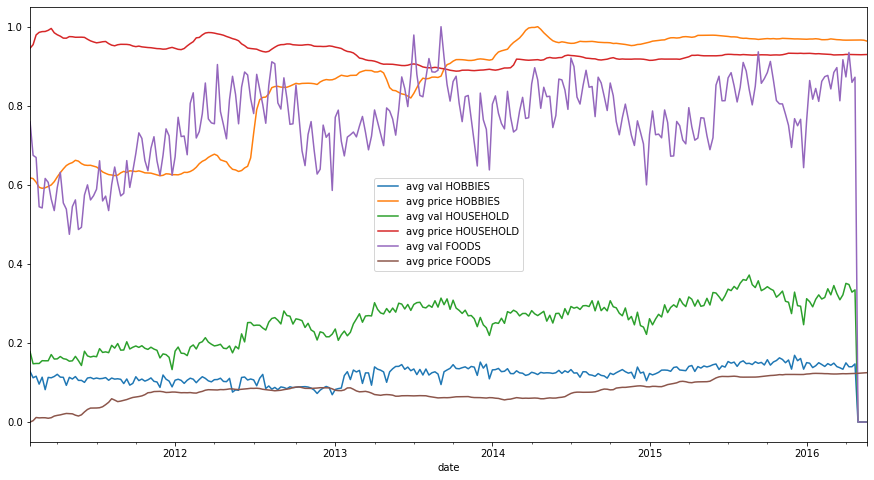

In [57]:
plt.figure(figsize=(15,8))
for i in sales_price.index.get_level_values(level=0).unique():
    sales_price.loc[i]['avg_val'].plot(x='date', y='avg_val', label = 'avg val' + ' ' +i)
    sales_price.loc[i]['avg_price'].plot(x='date', y='avg_price', label = 'avg price'+" " + i)
plt.legend()
plt.show()

It seems that there is not much relationship when seperating only by categories. This could be because the visualisation is too aggregated and does not represent the data well enough.

<a id='snapaffect'></a>
### Finding when will SNAP purchases affect sales volume

In [46]:
snap_ca_difference = CA_train[CA_train['snap_CA']==1].copy()
snap_ca_difference = snap_ca_difference.groupby(['store_id','week'])['value'].sum()

In [47]:
idx = pd.IndexSlice
snap_ca_difference = snap_ca_difference.loc[idx['CA_1':'CA_4',:]].copy()
indexing_stores = snap_ca_difference.index.get_level_values(level=0).unique()

In [48]:
snap_ca_difference

store_id  week
CA_1      1       123334.0
          2        64230.0
          5       106951.0
          6       129297.0
          7        13427.0
                    ...   
CA_4      48       15315.0
          49       71368.0
          50       22543.0
          52        1418.0
          53        6988.0
Name: value, Length: 148, dtype: float32

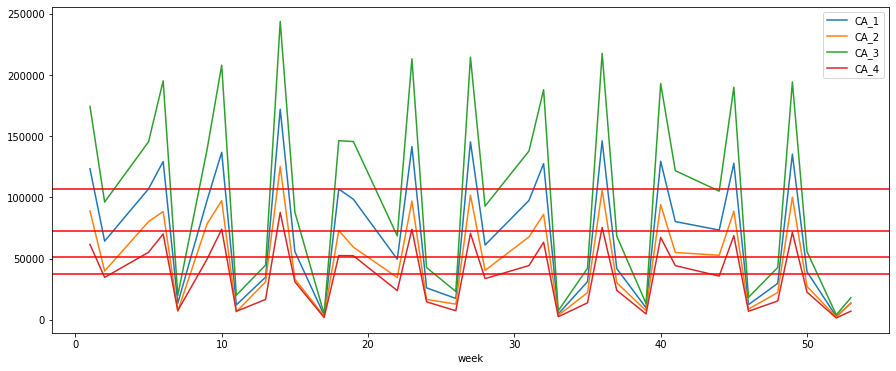

In [49]:
plot_full(snap_ca_difference,indexing_stores, 4, False)

Similarly, it seems that across all the shops, the highest volume of items sold are $\approx$ every 4 weeks. This is probably when the payouts for SNAP purchases are(or more specifically, when they company is able to make a difference). 
